<a href="https://colab.research.google.com/github/SAMashiyane/Residual_CNN_Explanation/blob/main/Residual_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Residual, BottleNeck, Inverted Residual, Linear BottleNeck, MBConv Explained**

In [1]:
!nvidia-smi 

Thu Mar 24 16:33:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import glob
import cv2
import shutil
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
from torchvision.models import resnet18, resnet34 ,resnet50
import os
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
use_gpu = torch.cuda.is_available()

use_gpu

True

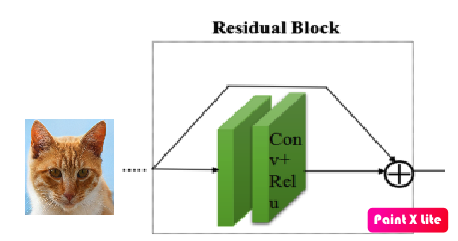

## **Residul Block**

### Residual Connections

In [3]:
# image size --> size_mage = 224*224
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2), # ---> [(w-f * 2p)/s +1] ==> (224-5+4/1)+1 = 224 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 3, kernel_size=5, padding=2), # 
            nn.BatchNorm2d(3),
            nn.ReLU(),
            # nn.MaxPool2d(2)
        )
        
        # self.fc = nn.Linear(56 * 56 * 32, 16)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        # out = out.view(out.size(0), -1)  # (bs, C * H, W)
        # out = self.fc(out)
        return out

## *Create a three-channel image tensor*

In [4]:
import torch
x = torch.randn((1, 3, 224, 224))
x.shape

torch.Size([1, 3, 224, 224])

## *Pass the image through the created model(block)*

In [5]:
block = SimpleCNN()
block(x).shape

torch.Size([1, 3, 224, 224])

## *Residual block creation class*

In [6]:
from torch import nn
from torch import Tensor

class ResidualAdd(nn.Module):
    def __init__(self,block):
        super().__init__()
        self.block = block
        
    def forward(self, x):
        res = x
        x = self.block(x)
        x += res
        return x


In [7]:
# image x 
x.shape

torch.Size([1, 3, 224, 224])

In [8]:
# image pass in model(block)
block(x).shape

torch.Size([1, 3, 224, 224])

In [9]:
# output = layer(input) + input. ---> output = block(image) + image
output = ResidualAdd(block)(x)
output.shape    

torch.Size([1, 3, 224, 224])

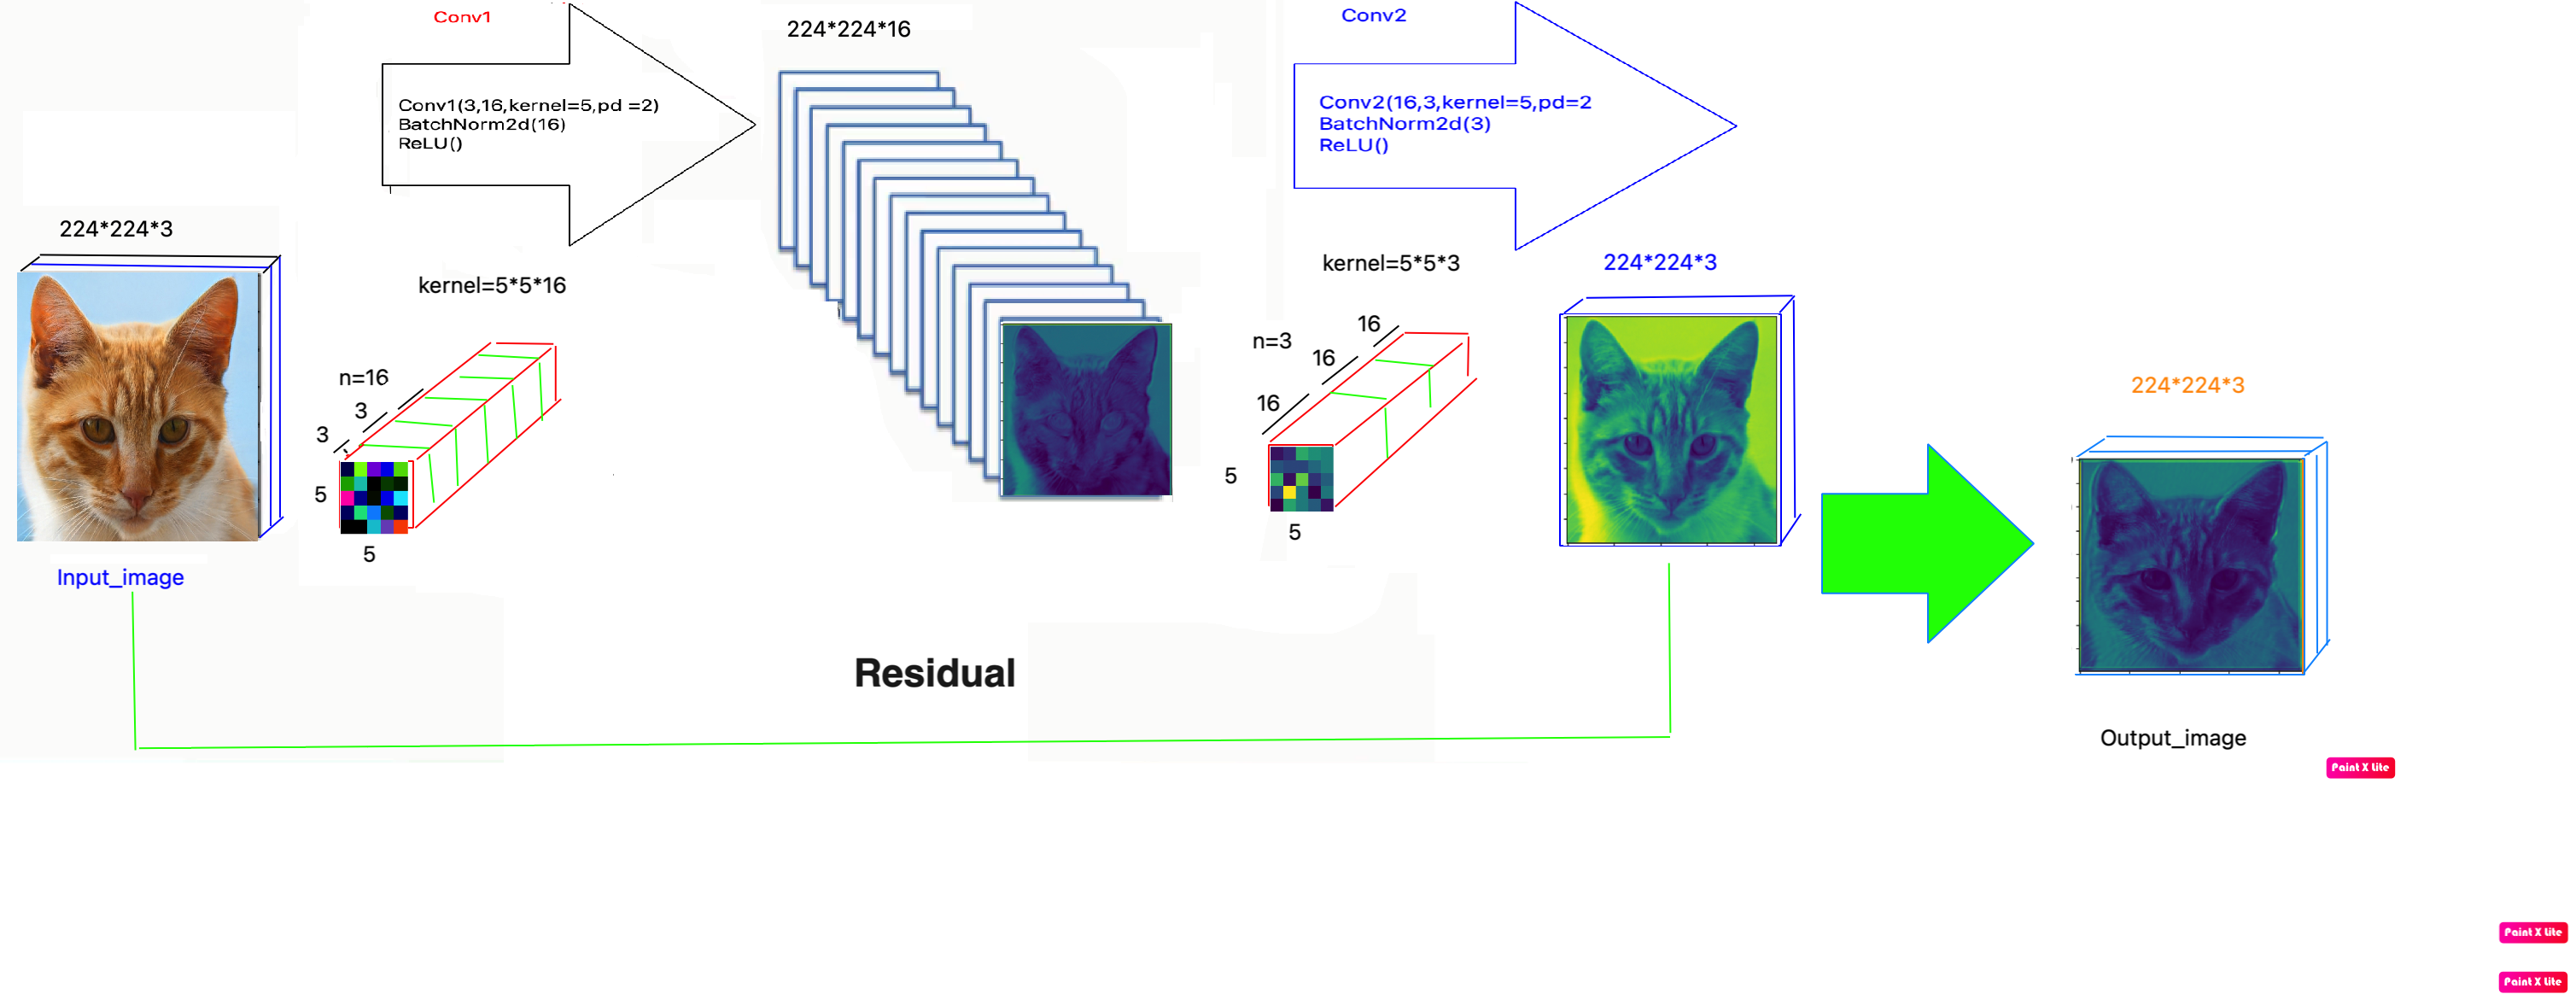

# **Visualization of CNN image(in Simple_model)**

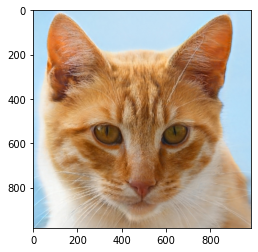

In [10]:
image = Image.open(str('/content/sample_data/cat.jpeg'))
plt.imshow(image)

In [11]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [12]:
block

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [13]:
model_children = list(block.children())
model_children

[Sequential(
   (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), Sequential(
   (0): Conv2d(16, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 )]

In [14]:
model_children[0]

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
block = block.to(device) # block~model

In [17]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


## **See the mean(sum/num) image after crossing the Conv1**

In [18]:
block.conv1

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

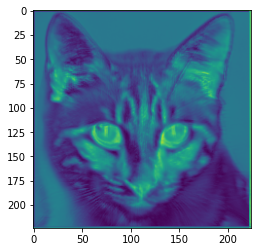

In [19]:
# image_cat  pass in conv1()
feature_map1 = block.conv1(image)
feature_map1.shape
#try show image after pass block
feature_map1 = feature_map1.squeeze(0)
feature_map1.shape
gray_scale1 = torch.sum(feature_map1,0)
gray_scale1= gray_scale1 / feature_map1.shape[0]
gray_scale1.shape
img_sum16 = gray_scale1.data.cpu().numpy()
type(img_sum16)
plt.imshow(img_sum16)
plt.show()

## **View images after crossing the Conv1(16_feature_map)**

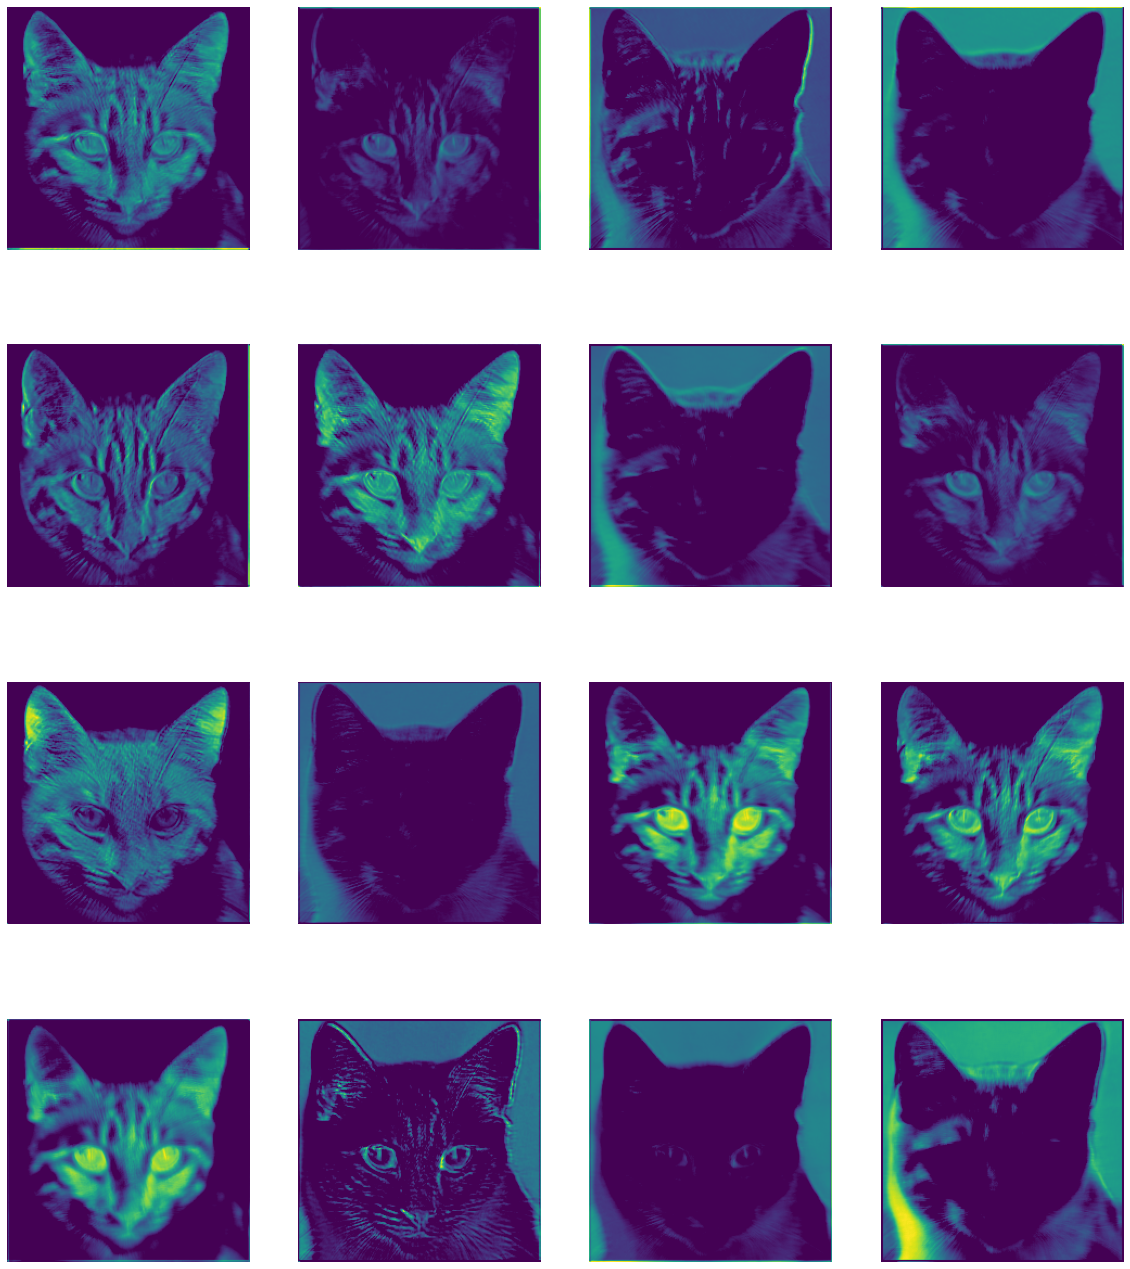

In [20]:
lst16 = []
for i in range(feature_map1.shape[0]):
  I16 = feature_map1[i:i+1,:,:].squeeze(0).data.cpu().numpy()
  lst16.append(I16)
fig = plt.figure(figsize=(20, 30))
for i in range(len(lst16)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(lst16[i])
    a.axis("off")
    # a.set_title(names[i].split('(')[0], fontsize=30)
# plt.savefig(str('feature_maps.jpg'))

## **See the mean(sum/num) image after crossing the block**

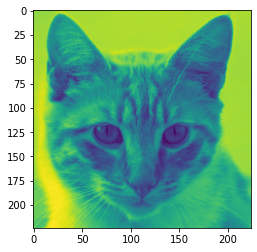

In [21]:
# image_cat  pass in model(block)
feature_map = block(image)
feature_map.shape
feature_map = block(image).shape
#try show image after pass block
feature_map = image.squeeze(0)
feature_map.shape
gray_scale = torch.sum(feature_map,0)
gray_scale = gray_scale / feature_map.shape[0]
gray_scale.shape
img = gray_scale.data.cpu().numpy()
type(img)
plt.imshow(img)
plt.show()

## **See one of the pictures after crossing the block**

In [22]:
feature_map.shape

torch.Size([3, 224, 224])

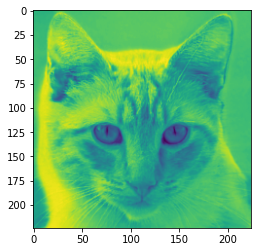

In [23]:
feature_map.shape
img1 = feature_map[0:1,:,:]
img1.shape
img2 =img1.squeeze(0)
img2.shape
img2 = img2.data.cpu().numpy()
plt.imshow(img2)
plt.show()

# **View images after crossing the block**

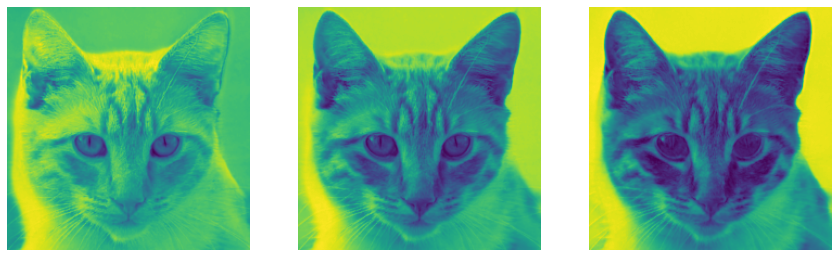

In [24]:
lst = []
for i in range(feature_map.shape[0]):
  I = feature_map[i:i+1,:,:].squeeze(0).data.cpu().numpy()
  lst.append(I)
fig = plt.figure(figsize=(20, 30))
for i in range(len(lst)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(lst[i])
    a.axis("off")
    # a.set_title(names[i].split('(')[0], fontsize=30)
# plt.savefig(str('feature_maps.jpg'))

## **See the mean(sum/num) image after crossing the residualblock**

<function matplotlib.pyplot.show>

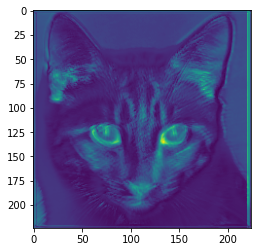

In [25]:
# output = layer(input) + input. ---> output = block(image) + image
output = ResidualAdd(block)(image)
output.shape  
output1 = output.squeeze(0) # decrease dim in torch tensor type
output1 = torch.sum(output1/3,0)
# output1.permute(2,1,0)
output2 = output1.data.cpu().numpy()
output2.shape #---> (224, 224)
plt.imshow(output2)
plt.show 

## **View images after crossing the Residuallblock**

In [26]:
output = output.squeeze(0)

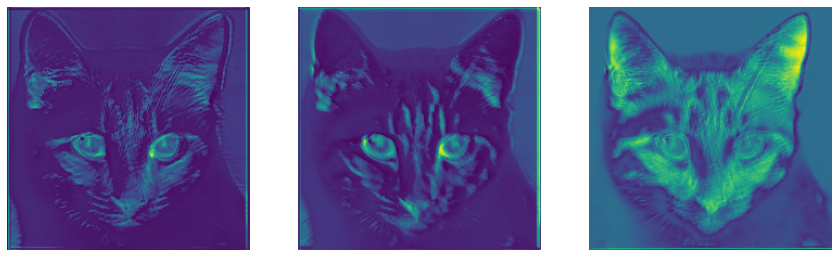

In [27]:
lst_output = []
for i in range(output.shape[0]):
  I = output[i:i+1,:,:].squeeze(0).data.cpu().numpy()
  lst_output.append(I)
fig = plt.figure(figsize=(20, 30))
for i in range(len(lst_output)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(lst_output[i])
    a.axis("off")
    # a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'))

## **See filter1 with random weights in the model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

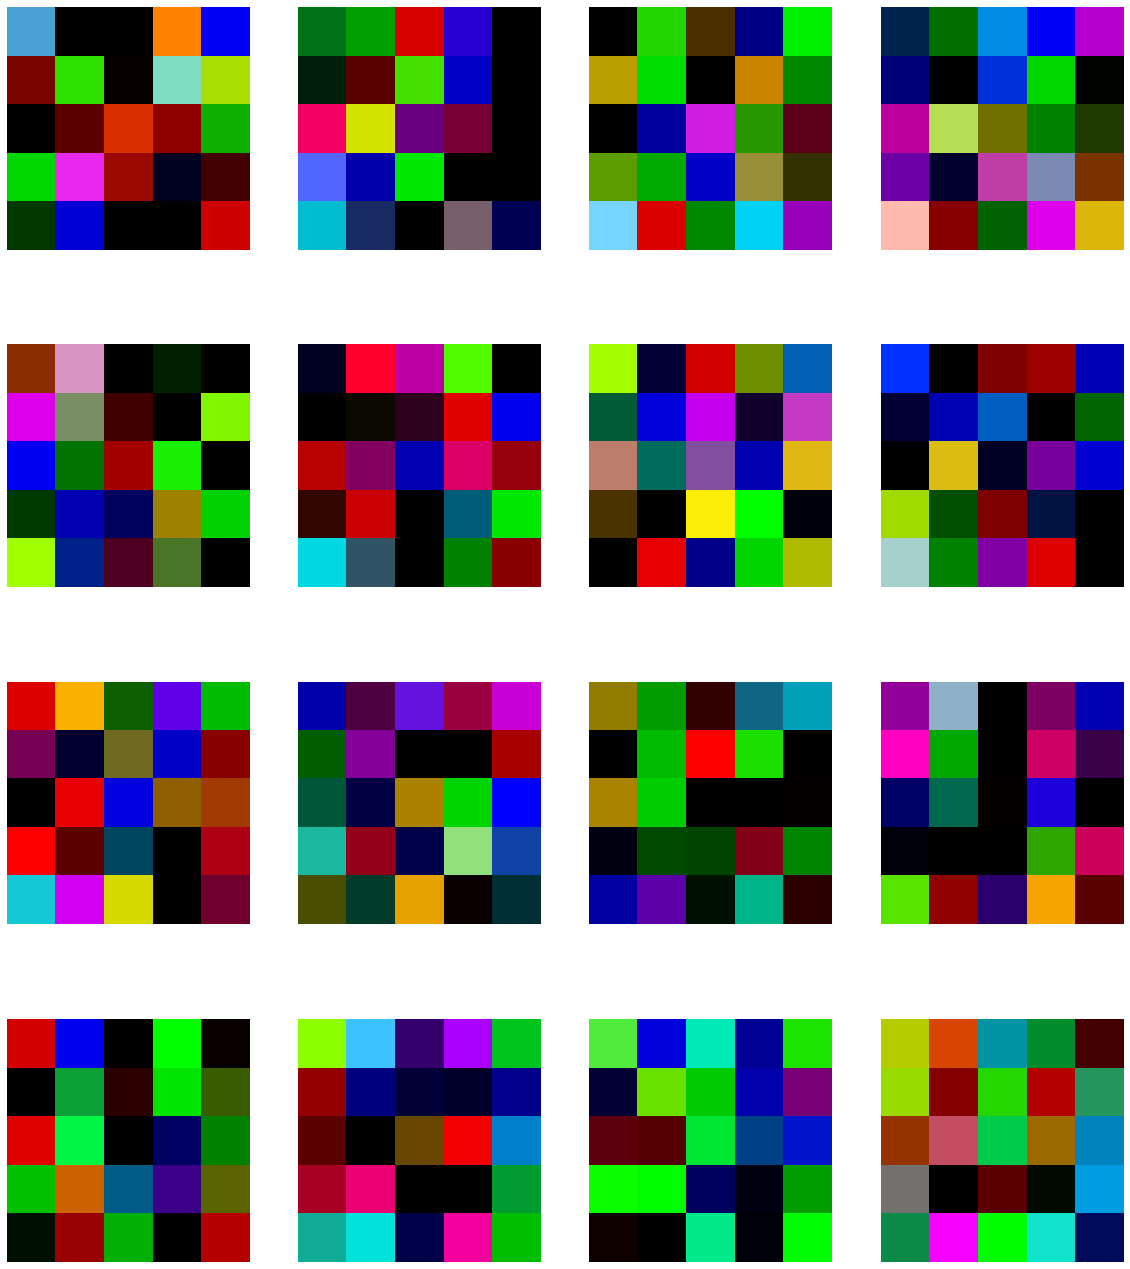

In [28]:

filters1 = block.conv1[0].weight
filters1.shape[0] # ----> n = 16
lst_filters1 = []
for i in range(filters1.shape[0]):
  f1 = filters1[i].permute(1,2,0).data.cpu().numpy() #  filter[1] -->(3,5,5) then convert position and numpy (5,5,3)
  f1 = f1/np.amax(f1) # in [0..1] for RGB 
  lst_filters1.append(f1)
fig = plt.figure(figsize=(20, 30))
for i in range(len(lst_filters1)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(lst_filters1[i])
    a.axis("off")


## **See filter2 with random weights in the model**

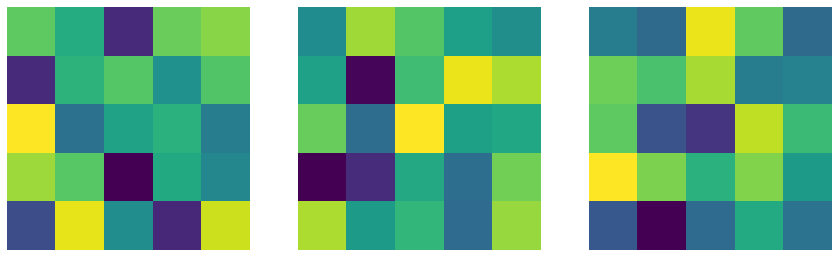

In [29]:
filters2 = block.conv2[0].weight
filters2[0].shape # ---> torch.Size([16, 5, 5])
filters2.shape[0] # ----> n = 3
lst_filters2 = []
for i in range(filters2.shape[0]):
  f2 = filters2[i]
  f2 = torch.sum(f2,0)
  f2= f2 / f2.shape[0]
  f2.shape
  f2_sum16 = f2.data.cpu().numpy()
  lst_filters2.append(f2_sum16)
fig = plt.figure(figsize=(20, 30))
for i in range(filters2.shape[0]):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(lst_filters2[i])
    a.axis("off")

# **Shortcut**

Sometimes your residual hasn't the same output's dimension, so we cannot add them. We can project the input using a conv in the shortcut (the black arrow with the +) to match your output's feature